# Readymade Data Module Assignment
## NYC 311 Service Request Analysis

**Student Name:** Nick Pisarczyk

**U-M Unique Name:** npisar

**Research Question:** RQ1: Do different neighborhoods have distinctive patterns in their 311 service requests? Analyze the relative frequency of complaint types across neighborhoods. What patterns do you notice?

---

**BEFORE YOU START:**
1. Read the assignment instructions on Canvas carefully.
2. Make a copy of this notebook and work on your own copy.
3. Understand the dataset before you start cleaning and analyzing. NYC Open Data has a nice portal and a data dictionary for exploring their datasets.
4. NYC 311 is a **very large** dataset. When you are fetching data from the portal or API, we would recommend you to first think about your research questions and start with a small subset of the data and then increase the size of the data as you get more comfortable with the data. Generally, you do **not** need to use the entire dataset to answer your research question.
5. This notebook serves as a template. You can add more cells or make adjustments as you see fit. But make sure to keep all the sections mentioned in the assignment instructions. Also, format your notebook properly for better readability.

## Data Statement

Describe your data source here. Include:
- Where you obtained the data (URL or API endpoint)
```
I didn't want to download a bunch of data that wasn't necessary for the RQ I chose, so I started with the API calls. I could filter the columns of data I wanted to use, and I had a lot more granular control over the data in a way I was already pretty comfortable with. I downloaded data per borough.

Once I gathered the data from the API, I saved each borough's data to pandas df objects, put all the dfs in a dictionary to be able to access easily later, and saved each of those dfs to csv files. Then, I went forward and read each CSV data file instead of calling the API over and over.

I wrote a few more lines to concatenate each individual csv for each borough into one pandas dataframe that I could use to create visualizations, etc.
```



<br><br><br>
- What subset you're analyzing (dates, geography, etc.)
```python
columns = [
    "unique_key",
    "created_date",
    "closed_date",
    "complaint_type",
    "descriptor",
    "descriptor_2",
    "borough"
]
```
```
This is the list of columns I used (see in context in Option B first cell how I filtered). I figured that to understand if 'different neighborhoods have distinctive patterns in their 311 service requests' and to 'Analyze the relative frequency of complaint types across neighborhoods', all I needed were the complaint type, some descriptors, the borough, and the basic unique key / created/closed date information. I tried to take only the necessary columns to keep the API calls short and filesizes small. I don't need most of the stuff available in the data!

This is also where a lot of my "data cleaning" happened. You can see that I got pretty specific in my API calls about what I wanted, so I didn't really need to clean much at all later.
```



<br><br><br>
- Any filters or sampling you applied
```python
results = client.get("erm2-nwe9", 
                    select=select_str,
                    where=f"created_date >= '2025-06-01' AND borough = '{borough}'",
                    limit=250000)
```
```
Some more code. I filtered on created_date and did that above date (only records after 2025-06-01), and then filtered by borough as I was iterating through the list (see in context in Option B's first cell). I used a limit of 250,000 because I wanted to gather around 100,000 records for Staten Island. Since Staten Island naturally has fewer 311 datapoints (as it's essentially a tourist island compared to the other 4 urban city boroughs), I thought this was a good balance of not having a ridiculous number of rows and crazy filesizes, but still having plenty of data to analyze and generalize with. 

Again, this is another example of the "pre-cleaning" I did, which means I didn't have to create any date ranges later or anything like that in the "data cleaning" section.
``` 

In [53]:
"""
File size and number of rows
"""
import os
folder = '../data/readymade_module_data'
print(f"===== File size/number of records =====")

for f in os.listdir(folder):
    name = f
    if f.endswith('.csv'):
        fp = os.path.join(folder, f)
        
        # filesize
        size = os.path.getsize(fp) / (1024 * 1024)
        
        # number of rows
        with open(fp, 'r', encoding='utf-8') as f:
            rows = sum(1 for line in f) - 1 
            
        print(f"{name}\nSize: {size:.1f}mb\nRows: {rows:,} rows\n")

===== File size/number of records =====
staten island.csv
Size: 10.0mb
Rows: 99,712 rows

bronx.csv
Size: 22.7mb
Rows: 250,000 rows

queens.csv
Size: 22.8mb
Rows: 250,000 rows

manhattan.csv
Size: 23.7mb
Rows: 250,000 rows

brooklyn.csv
Size: 23.2mb
Rows: 250,000 rows



## Assignment Details (Canvas)

https://umich.instructure.com/courses/825993/assignments/3016485

**Overview**
This assignment asks you to analyze NYC 311 service request data to understand patterns in urban neighborhoods. You will use Python to explore relationships between service requests and socioeconomic characteristics, practicing skills in data cleaning, exploratory analysis, visualization, and interpretation.

311 systems allow residents to report non-emergency issues like noise complaints, street conditions, and building problems. As Wang et al. (2017) demonstrated, these service request patterns can reveal distinctive “signatures” of urban neighborhoods that correlate with demographic and economic characteristics.

---

**Learning Objectives**<br>
By completing this assignment, you will:<br>
- Practice working with “readymade” administrative data from government sources
- Develop skills in data cleaning and exploratory data analysis
- Apply statistical methods to understand relationships in observational data
- Create effective visualizations to communicate data patterns
- Consider methodological limitations and ethical implications of using administrative data for research
- Data

---

**NYC Open Data - 311 Service Requests**

You will use NYC’s publicly available 311 service request dataLinks to an external site..

Recommended approach: Explore the dataset using the NYC Open Data online portal and the data dictionary. The full dataset is very large (40+ million records), so filtering is essential. For instance, one year of data was around 2.6 GB. 

Based on your research question, identify an appropriate subset of the data (e.g., one year of data for specific boroughs or zip codes), and use the Socrata API or directly download it.You can find more information about the API and the documentation on NYC Open Data website.

---

**Research Questions**
Choose ONE of the following research questions to investigate:

- Option 1: Neighborhood Service Request Signatures
<br>Do different neighborhoods have distinctive patterns in their 311 service requests? Analyze the relative frequency of complaint types across neighborhoods. What patterns do you notice?

- Option 2: Temporal Patterns in Service Requests
<br>How do 311 service requests vary by time of day, day of week, or season? Are there particular complaint types that show strong temporal patterns? What might explain these patterns?

- Option 3: Response Time Disparities
<br>Do response times for 311 requests differ across neighborhoods or complaint types? Calculate the time between request creation and closure, and examine whether there are systematic differences by location or complaint category.

- Option 4: Complaint Type Evolution
<br>How have the types and volumes of 311 requests changed over time (comparing multiple years)? What might explain these patterns?

---

**Assignment Requirements**<br>
Your submission should include two components. Both should be included in a single Jupyter Notebook.
<br>
1. Data Analysis<br>
Your notebook should include:

- Data loading and initial exploration: Load the data, explain how you retrieve the data, why you choose the specific subset, examine its structure, and identify relevant variables
- Data cleaning: Handle missing values, filter to relevant records, create derived variables as needed
- Exploratory analysis: Use descriptive statistics and visualizations to understand patterns
- Focused analysis: Apply appropriate statistical methods to address your research question
- Visualizations: Create at least 3 meaningful visualizations (e.g., time series, bar charts, heatmaps, scatter plots)
- Documentation: Include markdown cells explaining your approach, interpreting results, and noting limitations
- Technical expectations: Use numpy/pandas for data manipulation, matplotlib/seaborn for visualization, and appropriate statistical libraries (scipy, statsmodels, etc.) as needed.

2. Written Summary<br>
Briefly report on the following. Your notebook should have a section for each bullet point.

- Research question and motivation: What is your research question? Why is this question interesting? What might we learn?
- Methods: Describe your data source, cleaning steps, and analytical approach
- Findings: Summarize key patterns and statistical results (include 2-3 key visualizations)
- Limitations: What are the methodological limitations? What can and cannot be concluded from this analysis?
- Ethical considerations: Reflect on the use of 311 data for research. Who is represented? Who might be excluded? What are potential concerns about using this data?
 
---

**Assignment Submission**

Please upload your Jupyter Notebook file to Canvas by the deadline: A single .ipynb file that includes all your work. 

Before submitting the file, ensure that your notebook is properly running on your machine. Ensure your notebook contains all your responses, plots, all programming parts of this assignment and is properly formatted with headings, explanations and code comments.

If you use Generative AI tools in any part of your assignment, you need to follow the AI policy in our syllabus and document your AI use at the end of your notebook.

## 1. Setup and Data Loading

In [55]:
# Import libraries
# You can import any libraries you may need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sodapy import Socrata
from scipy.stats import chi2_contingency

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [13]:
# save to csv helper function
def df_to_csv(d):
    for borough, df in d.items():
        df.to_csv(f"../data/readymade_module_data/{borough}.csv", index=False)

In [14]:
# helper f for print output
def spacer_top(i=50):
    print(f"{'='*i}")
    print(f"{'='*i}")

def spacer_bottom(i=50):
    print(f"{'='*i}")
    print(f"{'='*i}")
    print(f"\n\n\n\n")

In [15]:
# no truncated output
pd.set_option('display.max_rows', None) # show all rows in the output
pd.set_option('display.max_columns', None) # show all columns in the output

# # reset options
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [ ]:
##################################################################################
############################ TODO: DONT KNOW IF NEEDED ###########################
##################################################################################

# function for generating an APA-style report for a statsmodels regression result
def apa_report(model):
    """
    Generate an APA-style report for a statsmodels regression result.
    Works with arbitrary numbers of predictors.
    """
    # Basic model info
    dep_var = model.model.endog_names
    exog_names = model.model.exog_names  # includes intercept (often 'const')
    params = model.params
    tvalues = model.tvalues
    pvalues = model.pvalues
    ses = model.bse

    r_squared = model.rsquared
    f_value = model.fvalue
    df_model = int(model.df_model)
    df_resid = int(model.df_resid)
    f_pvalue = model.f_pvalue

    # Identify predictors (exclude intercept if present)
    # Common names for intercept are 'const' or 'Intercept'
    intercept_names = {"const", "Intercept", "intercept"}
    predictors = [name for name in exog_names if name not in intercept_names]

    # Intro sentence: outcome and predictors
    if len(predictors) == 1:
        predictor_text = predictors[0]
        intro = (
            f"A linear regression was conducted to predict {dep_var} from "
            f"{predictor_text}. "
        )
    else:
        predictor_text = ", ".join(predictors[:-1]) + f", and {predictors[-1]}"
        intro = (
            f"A multiple linear regression was conducted to predict {dep_var} from "
            f"{predictor_text}. "
        )

    # Overall model fit
    if f_pvalue < 0.05:
        significance_phrase = "was statistically significant"
    else:
        significance_phrase = "was not statistically significant"

    model_fit = (
        f"The regression equation {significance_phrase}, F({df_model}, {df_resid}) = "
        f"{f_value:.2f}, p = {f_pvalue:.3f}, with an R² of {r_squared:.2f}. "
    )

    # Coefficients section
    coef_sentences = []
    for pred in predictors:
        slope = params[pred]
        t_val = tvalues[pred]
        p_val = pvalues[pred]
        se = ses[pred]
        coef_sentence = (
            f"The slope for {pred} was {slope:.2f} (SE = {se:.2f}), "
            f"t({df_resid}) = {t_val:.2f}, p = {p_val:.3f}."
        )
        coef_sentences.append(coef_sentence)

    report = intro + model_fit + " ".join(coef_sentences)
    return report


### Option A: Load from downloaded CSV file

**Note**: If you are running the notebook using `colab` kernel, you **cannot** directly import the data from your own laptop. Please see the class repo README files for more details

In [ ]:
# Load your downloaded data

# df setup
# define the 5 NYC boroughs (neighborhoods)
boroughs = [
    "BRONX",
    "BROOKLYN",
    "MANHATTAN",
    "QUEENS",
    "STATEN ISLAND"
]

dfs = {}

# add each to dict
for borough in boroughs:
    print(f"{borough} data added...")
    dfs[borough.lower()] = pd.read_csv(f'../data/readymade_module_data/{borough.lower()}.csv', 
                    low_memory=False)
# print(f"dfs keys is {dfs.keys()}")


# combine these dfs into one df to make it easier to work with
df = pd.concat(dfs.values(), ignore_index=True)
print(f"Full df created!")

BRONX data added...
BROOKLYN data added...
MANHATTAN data added...
QUEENS data added...
STATEN ISLAND data added...
Full df created!


### Option B: Load from Socrata API (recommended for smaller datasets)

In [18]:
# """
# Should only have to do this once. Created this code to gather data with the columns I wanted, and then saved them to CSVs for easy access.
# """



# client = Socrata("data.cityofnewyork.us", None)
# client.timeout = 60

# # specify columns to reduce runtimes and get only pertinent data
# columns = [
#     "unique_key",
#     "created_date",
#     "closed_date",
#     "complaint_type",
#     "descriptor",
#     "descriptor_2",
#     "borough"
# ]
# select_str = ', '.join(columns)

# # df setup
# # define the 5 NYC boroughs (neighborhoods)
# boroughs = [
#     "BRONX",
#     "BROOKLYN",
#     "MANHATTAN",
#     "QUEENS",
#     "STATEN ISLAND"
# ]

# dfs = {}

# # find data for each borough and create 5 separate dfs
# for borough in boroughs:
#     print(f"Gathering data for borough: {borough}...")
#     results = client.get("erm2-nwe9", 
#                         select=select_str,
#                         where=f"created_date >= '2025-06-01' AND borough = '{borough}'",
#                         limit=250000)
#     dfs[borough.lower()] = pd.DataFrame.from_records(results)

#     print(f"Converting time columns...")
#     # Convert date columns
#     dfs[borough.lower()]['created_date'] = pd.to_datetime(dfs[borough.lower()]['created_date'])
#     dfs[borough.lower()]['closed_date'] = pd.to_datetime(dfs[borough.lower()]['closed_date'])

#     if not borough == "STATEN ISLAND":
#         print(f"Complete! Next bourough...\n\n")
#     else:
#         print(f"Complete for all boroughs!")
    
# print(f"dfs dict is:\n{dfs}")


In [19]:
# """
# Like last cell, should only have to do this once. Created this code to save gathered data to CSVs for easy access, not needed once CSVs already on machine.
# """

# # save to CSV for easier access
# df_to_csv(dfs)

## 2.Data Description

You can describe the data in many ways. Here are some baseline requirements:
- Display basic information about the dataset (what are the relevant variables? What are their types? How many observations are there?)
- Conduct summary statistics of the relevant variables
- Check for missing values

In [20]:
"""
Data Heads
Preview all the data
"""

# See data heads
print(df.head())
print(df.shape)

   unique_key         created_date   complaint_type   descriptor  \
0    67654136  2026-01-28 18:19:00    PAINT/PLASTER      CEILING   
1    67654148  2026-01-28 11:54:43    PAINT/PLASTER         WALL   
2    65150823  2025-06-03 06:17:00      DOOR/WINDOW  WINDOW PANE   
3    65150833  2025-06-03 16:08:40  FLOORING/STAIRS        FLOOR   
4    65152252  2025-06-03 20:31:15       WATER LEAK   HEAVY FLOW   

              descriptor_2 borough          closed_date  
0          HOLE OR CRACKED   BRONX                  NaN  
1     BULGING/HOLE/CRACKED   BRONX                  NaN  
2  GLASS BROKEN OR MISSING   BRONX  2025-08-08 06:52:30  
3      BROKEN OR DEFECTIVE   BRONX  2025-06-22 17:44:36  
4       AT WALL OR CEILING   BRONX  2025-07-10 21:17:39  
(1099712, 7)


In [33]:
"""
Missing Values

Check for what columns have missing values
We should find only closed_date, descriptor, and descriptor 2 have any N/A values across all the data
if that's the case, we don't need to remove any rows
"""
print(f"Columns with missing values: {df.columns[df.isna().any()].tolist()}")

Columns with missing values: ['descriptor', 'descriptor_2', 'closed_date']


In [54]:
"""
Complaint Type Counts

Figure out what percentage of complaints the top three complaint types make up in each borough's dataset
"""

# for borough in dfs.keys():
#     spacer_top(75)

#     # init percentages dict
#     percentages = {}

#     # get the percentages from pandas and store in var p
#     p = dfs[f'{borough}']['complaint_type'].value_counts(normalize=True).mul(100)
    
#     # iterate through the top 3 and save their name and percentage values
#     for i in range(0,5):
#         label = p.index[i]
#         val = p.iloc[i]
#         percentages[f'{label}'] = val

#     # print output
#     print(f"{borough.upper()}: Top 5 Complaint Types")
#     i = 1
#     for label in percentages:
#         print(f"{i}. {label}. {percentages[f'{label}']:.2f}% of all complaints in {borough.upper()}")
#         i+=1

#     spacer_bottom(75)



"\nComplaint Type Counts\n\nFigure out what percentage of complaints the top three complaint types make up in each borough's dataset\n"

## 3. Data Cleaning

Document your cleaning decisions and rationale here

In [ ]:
# ## group by month -- show how they change over time

"""
A note here: most of my data cleaning was done when I was gathering the data.
See the markdown block in my data statement for a more complete description
"""

# 1. Make sure rows with missing essential data are removed
df_clean = df.dropna(subset=('created_date', 'complaint_type', 'borough'))


# output
print(f"Original dataset: {len(df)} records")
print(f"Cleaned dataset: {len(df_clean)} records")
print(f"Removed: {len(df) - len(df_clean)} records ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")

Original dataset: 1099712 records
Cleaned dataset: 1099712 records
Removed: 0 records (0.0%)


## 4.Exploratory Data Analysis

Add narrative about what you're exploring, why and what you've found

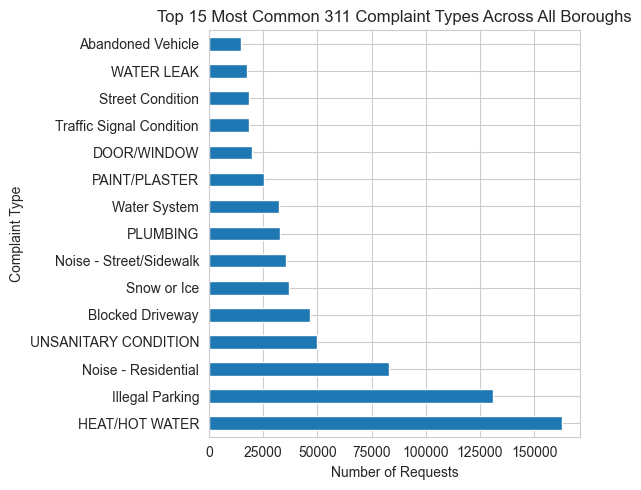

In [ ]:
########################################################
########################################################
########################################################

# TODO: WHAT GOES HERE?

########################################################
########################################################
########################################################

"""
Graph of most common complaint types across all boroughs
"""
complaint_counts = df_clean['complaint_type'].value_counts().head(15)
plt.figure(figsize=(6, 5))
complaint_counts.plot(kind='barh')
plt.xlabel('Number of Requests')
plt.ylabel('Complaint Type')
plt.title('Top 15 Most Common 311 Complaint Types Across All Boroughs')
plt.tight_layout()
plt.show()


Top 10 311 Complaint Types in Bronx:
complaint_type
HEAT/HOT WATER             55082
Noise - Residential        23835
Illegal Parking            20164
UNSANITARY CONDITION       16912
PLUMBING                   11863
Noise - Street/Sidewalk    11295
Water System               10366
PAINT/PLASTER               9422
Blocked Driveway            7830
DOOR/WINDOW                 6901
Name: count, dtype: int64


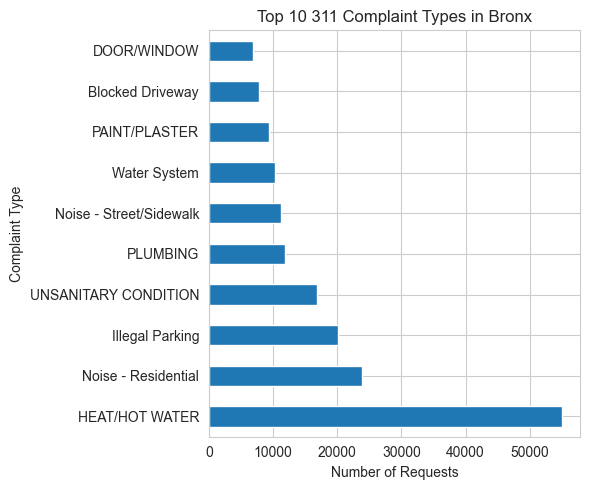







Top 10 311 Complaint Types in Brooklyn:
complaint_type
HEAT/HOT WATER          44263
Illegal Parking         36913
Noise - Residential     15439
UNSANITARY CONDITION    14660
Snow or Ice             13093
Blocked Driveway        12631
PLUMBING                 9292
PAINT/PLASTER            7089
DOOR/WINDOW              6136
WATER LEAK               5529
Name: count, dtype: int64


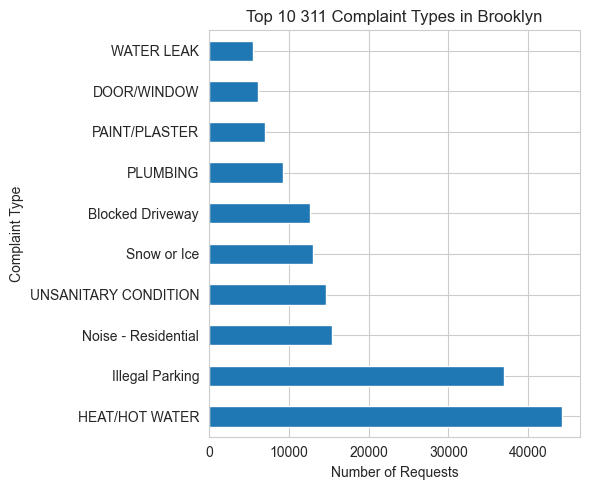







Top 10 311 Complaint Types in Manhattan:
complaint_type
HEAT/HOT WATER                39731
Noise - Residential           19333
Illegal Parking               17538
Noise - Street/Sidewalk       14472
Encampment                    10066
UNSANITARY CONDITION           9733
Homeless Person Assistance     7155
PLUMBING                       6595
Water System                   5974
Noise                          5691
Name: count, dtype: int64


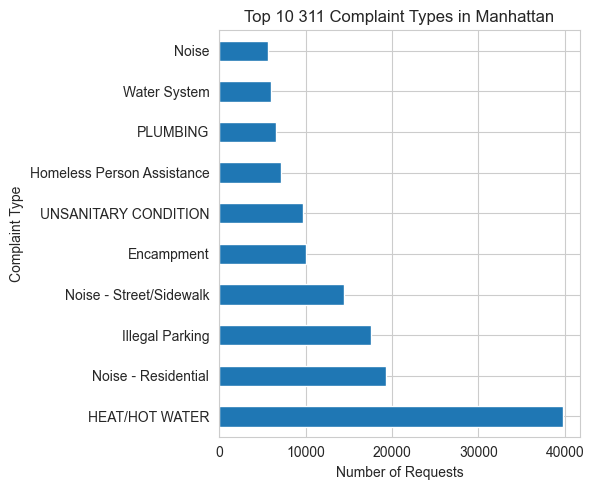







Top 10 311 Complaint Types in Queens:
complaint_type
Illegal Parking            44263
HEAT/HOT WATER             21244
Blocked Driveway           20704
Noise - Residential        16846
Snow or Ice                11068
Water System                7263
UNSANITARY CONDITION        6816
Street Condition            6770
Abandoned Vehicle           6103
Noise - Street/Sidewalk     6064
Name: count, dtype: int64


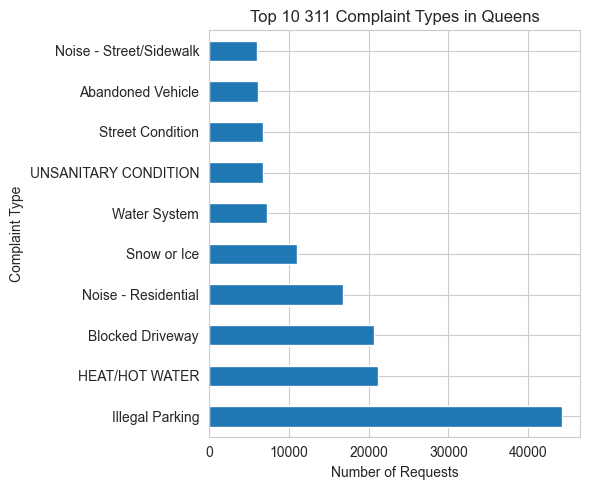







Top 10 311 Complaint Types in Staten Island:
complaint_type
Illegal Parking           12139
Noise - Residential        7394
Snow or Ice                5811
Water System               4676
Blocked Driveway           4071
Missed Collection          4010
Street Condition           3924
Abandoned Vehicle          3585
Street Light Condition     3345
Damaged Tree               2948
Name: count, dtype: int64


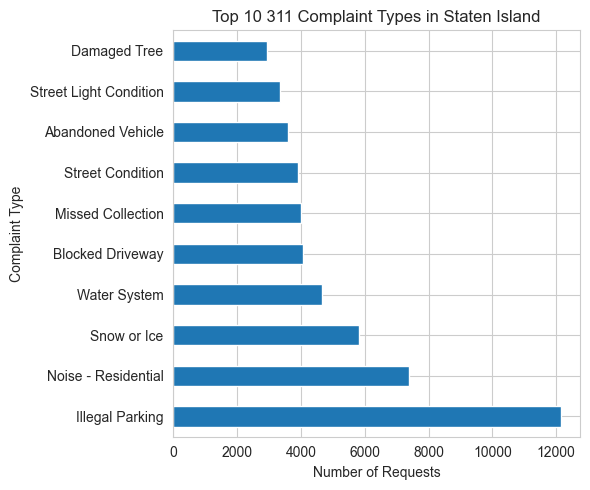

In [ ]:
"""
Graphs of most common complaint types per borough
"""

boroughs = df_clean['borough'].unique()

# number of results to show
top_n = 10
for borough in boroughs:
    spacer_top(75)
    
    borough_df = df_clean[df_clean['borough'] == borough]
    complaint_counts = borough_df['complaint_type'].value_counts().head(top_n)

    # output
    print(f"\nTop {top_n} 311 Complaint Types in {borough.title()}:")
    print(complaint_counts)
    
    # graph
    plt.figure(figsize=(6, 5))
    complaint_counts.plot(kind='barh')
    plt.xlabel('Number of Requests')
    plt.ylabel('Complaint Type')
    plt.title(f'Top {top_n} 311 Complaint Types in {borough.title()}')
    plt.tight_layout()
    plt.show()

    spacer_bottom(75)

## 5.Research Question Analysis

This is the core of your assignment. Document your analytical approach here. You can add any cells if you see fit.

In [28]:
# Your focused analysis goes here
# This will vary significantly based on your research question. You can organize your analysis as you like. You can have as many cells as you want.

### Statistical Testing (if applicable)

In [65]:
top_n = 10

# get the top n complaints
complaints = df_clean['complaint_type'].value_counts().head(top_n).index
subset_df = df_clean[df_clean['complaint_type'].isin(complaints)]

contingency_table = pd.crosstab(subset_df['borough'], subset_df['complaint_type'])

# Run the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared test statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.2f}")  # Shows up to 10 decimal places!

Chi-squared test statistic: 101933.02237350518
Degrees of freedom: 36
P-value: 0.00


## Key Visualizations

Create at least 3 polished visualizations that answer your research question

In [57]:
# Visualization 1
# Your code here

Interpretation of Visualization 1

In [ ]:
# Visualization 2
# Your code here

Interpretation of Visualization 2

In [ ]:
# Visualization 3
# Your code here

Interpretation of Visualization 3

## Written Summary

Summarize your key findings here. What patterns did you discover? What can you conclude?

UMGPT 1<br>
Statistical Analysis of Complaint Types by Borough
A chi-squared test of independence was conducted to examine whether the distribution of the ten most common 311 complaint types differs across New York City boroughs. The contingency table included complaint counts for each borough and complaint type.
The test produced a chi-squared statistic of 101,933.02 with 36 degrees of freedom and a p-value < 0.0000000000 (essentially zero).
Interpretation:Because the p-value is so much less than the conventional threshold of 0.05, we reject the null hypothesis that complaint type distributions are the same across boroughs. There are highly statistically significant differences in the kinds of complaints residents make in different boroughs.
In plain English:The types of complaints vary very significantly by borough—so a Bronx resident is likely making different types of complaints than a Brooklyn resident, and so on.

Let me know if you’d like a more detailed breakdown or want to visualize which specific complaint types drive the differences!
<br><br>
////////////////////////////////////////////////////
<br><br>
UMGPT 2<br>
APA-Style Statistical Analysis
A chi-square test of independence was conducted to examine the association between borough and complaint type for the ten most common 311 complaints in New York City. The results indicated a statistically significant difference in the distribution of complaint types across boroughs, χ²(36) = 101,933.02, p < .001.
These findings suggest that the types of complaints reported to 311 vary substantially by borough. Residents in different boroughs are more likely to report certain types of complaints compared to others.

### Research Question and Motivation

- Why is this question interesting? 
- What might we learn?

### Methods

Describe your data source, cleaning steps, and analytical approach

### Findings

Summarize key patterns and statistical results (refer to your key visualizations)

### Limitations

Discuss methodological limitations. What are the potential biases in 311 data? What alternative explanations exist for your findings? What can and cannot be concluded from this analysis?

### Ethical Considerations

Reflect on the ethical implications of using 311 data:
- Who is represented in this data? Who might be underrepresented?
- What are potential privacy concerns?
- How might this analysis be used or misused?
- What are the implications for equity and justice?

## AI Appendix (if applicable)

If you used AI during this assignnment, explain
1. what part of the work it was used for; 
2. what AI tools you used; 
3. the prompts you used; 
4. how you analyzed the AI work for accuracy; and, 
5. steps you took to rework and revise your final documents so that they were both factually accurate and reflected your own voice and style.


The only AI tool I used was U-M GPT

- I used AI to figure out how to do a chi-squared test in scipy since I've never done that before, on my own or in class
- I fed AI my code showing how I created visualizations and some of the output that I got, then I asked it "I need to run a chi squared test to figure out if there really are differences in complaint types by borough. How can I code that?"
- I didn't know what some of the code was, so I asked AI to explain it. "What does the subset_df do" and "What about .crosstab". I used google to figure out what a contingency table is, since I didn't know what that was either.
- I cross-referenced AI with google searches and some of my own research.
- I renamed variables in a way that made sense to me, and got rid of any complicated logic I didn't understand. I tried to ask AI to tell me what things I didn't understand meant so I could learn what it was doing and how I might structure some of my future code and statistical analysis.

## Submission

Submit your assignment as .ipynb file. Make sure to double check with the assignment instructions on Canvas.